<div style="text-align: center;">

# *Báo cáo Khai phá dữ liệu và phân tích dữ liệu*
# *Linear Regression in AMD stock price prediction*</div>

- **<font color='red'>Các thành viên nhóm :</font>**  
  ***Trần Phúc Hưng***  
  ***Nguyễn Ngọc Thạch***  
  ***Nguyễn Sĩ Hồng Quân***  
  ***Trần Xuân Đạt***  
  ***Hoàng Đức Duy***
</div>

In [103]:
#import libraries
import pandas as pd
import numpy as np
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

import graphviz

from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import datasets
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import joblib

# **1. Tiền xử lý dữ liệu**

In [104]:
#load data
datafile = pd.read_csv("AMD (1980 -11.07.2023).csv")
datafile.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-18,0.0,3.125000,2.937500,3.031250,3.031250,727200
1,1980-03-19,0.0,3.083333,3.020833,3.041667,3.041667,295200
2,1980-03-20,0.0,3.062500,3.010417,3.010417,3.010417,159600
3,1980-03-21,0.0,3.020833,2.906250,2.916667,2.916667,130800
4,1980-03-24,0.0,2.916667,2.635417,2.666667,2.666667,436800


In [105]:
#check file info
datafile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10919 entries, 0 to 10918
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10919 non-null  object 
 1   Open       10919 non-null  float64
 2   High       10919 non-null  float64
 3   Low        10919 non-null  float64
 4   Close      10919 non-null  float64
 5   Adj Close  10919 non-null  float64
 6   Volume     10919 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 597.3+ KB


In [106]:
datafile.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,10919.0,1.684266e+01,2.331772e+01,0.00,4.960000e+00,9.875000e+00,1.612500e+01,1.632800e+02
High,10919.0,1.751074e+01,2.360961e+01,1.69,5.437500e+00,1.006250e+01,1.640312e+01,1.644600e+02
Low,10919.0,1.676163e+01,2.261540e+01,1.61,5.125000e+00,9.630000e+00,1.580500e+01,1.561000e+02
Close,10919.0,1.713893e+01,2.312162e+01,1.62,5.300000e+00,9.875000e+00,1.612000e+01,1.619100e+02
Adj Close,10919.0,1.713893e+01,2.312162e+01,1.62,5.300000e+00,9.875000e+00,1.612000e+01,1.619100e+02
Volume,10919.0,1.846495e+07,2.815631e+07,0.00,1.226100e+06,6.833200e+06,2.284015e+07,3.250584e+08


In [107]:
#Add Prev_close column to store previous close price
series_shifted = datafile['Close'].shift()
datafile['Prev_close'] = series_shifted
datafile.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Prev_close
0,1980-03-18,0.0,3.125000,2.937500,3.031250,3.031250,727200,NaN
1,1980-03-19,0.0,3.083333,3.020833,3.041667,3.041667,295200,3.031250
2,1980-03-20,0.0,3.062500,3.010417,3.010417,3.010417,159600,3.041667
3,1980-03-21,0.0,3.020833,2.906250,2.916667,2.916667,130800,3.010417
4,1980-03-24,0.0,2.916667,2.635417,2.666667,2.666667,436800,2.916667


In [114]:
#null entries check (need to remove those data)
datafile.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Prev_close    1
dtype: int64

In [123]:
#drop / remove NaN row or column
#inplace = true to execute dropna right on it file so python
#dont have to create a copy and we have to re-initialize and
#add to a new datafile variable
datafile.dropna(inplace = True)
datafile.shape

(10918, 8)

In [124]:


# Hàm để xóa cột 'Adj Close'
def remove_columns(datafile, columns_to_remove):
    # Lặp qua các cột cần xóa và kiểm tra xem cột đó có tồn tại trong tập dữ liệu không
    for column in columns_to_remove:
        if column in datafile.columns:
            datafile = datafile.drop(columns=[column])  # Xóa cột
            print(f"Cột '{column}' đã được xóa.")
        else:
            print(f"Cột '{column}' không tồn tại trong tập dữ liệu.")
    return datafile

# Cột cần xóa (chỉ xóa 'Adj Close')
columns_to_remove = ['Adj Close']

# Áp dụng hàm xóa cột 'Adj Close'
df_cleaned_without_columns = remove_columns(datafile, columns_to_remove)

# Lưu tập dữ liệu mới
df_cleaned_without_columns.to_csv("AMD_(1980 -11.07.2023).csv_without_Adj_Close.csv", index=False)

# Thông báo kết quả
print("Tập dữ liệu đã được lưu.")


Cột 'Adj Close' đã được xóa.
Tập dữ liệu đã được lưu.


# **2. Phân tích bộ dữ liệu**

In [125]:
df = pd.read_csv('AMD_(1980 -11.07.2023).csv_without_Adj_Close.csv')
df.shape

(10918, 7)

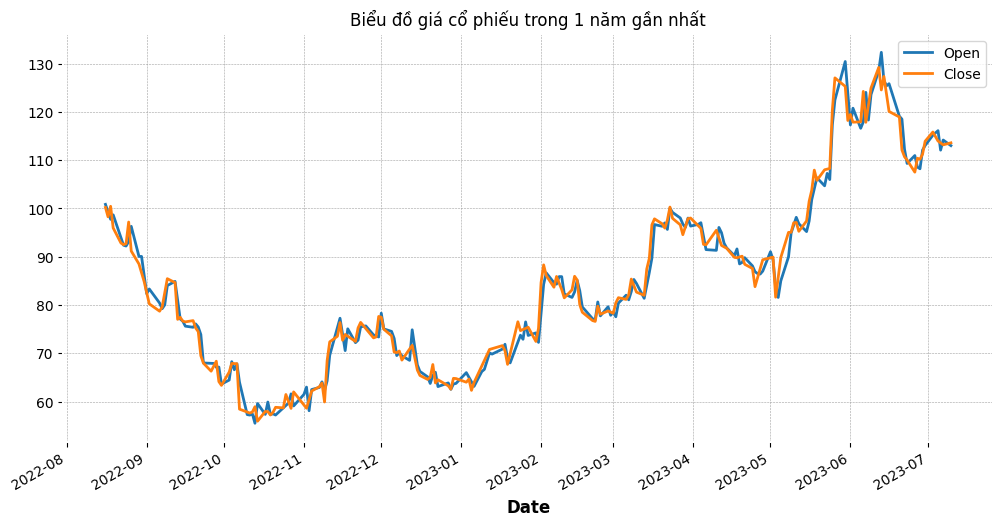

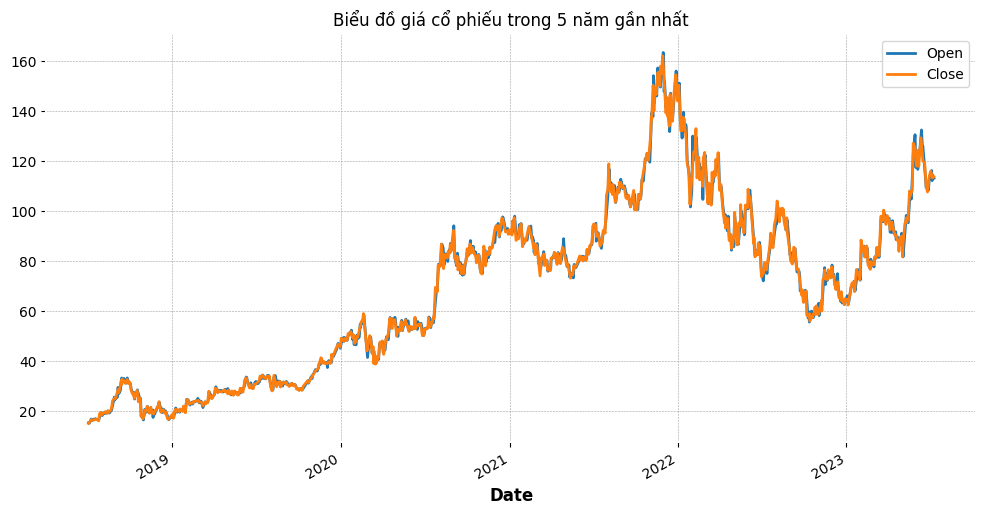

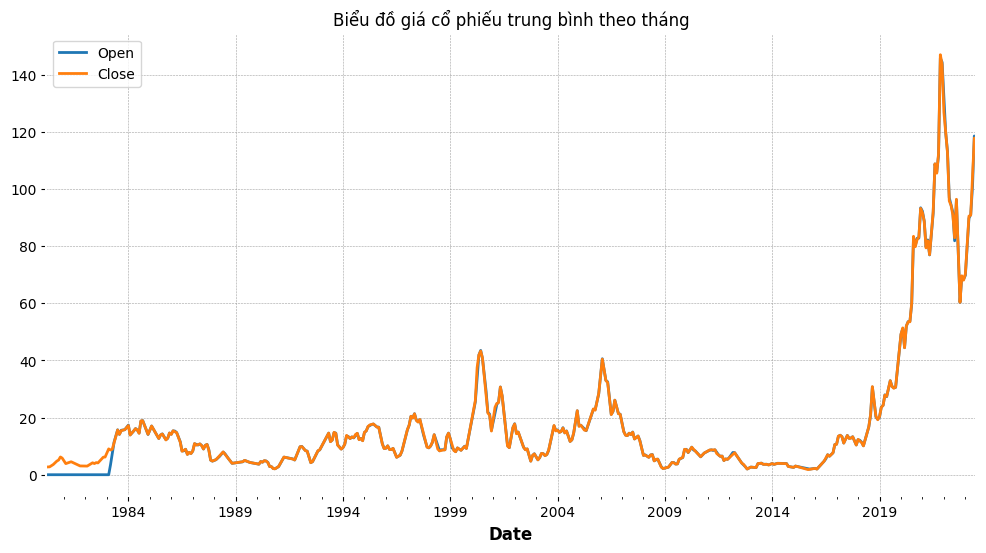

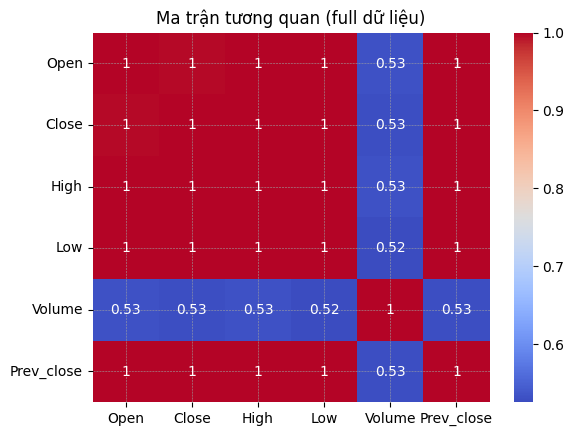

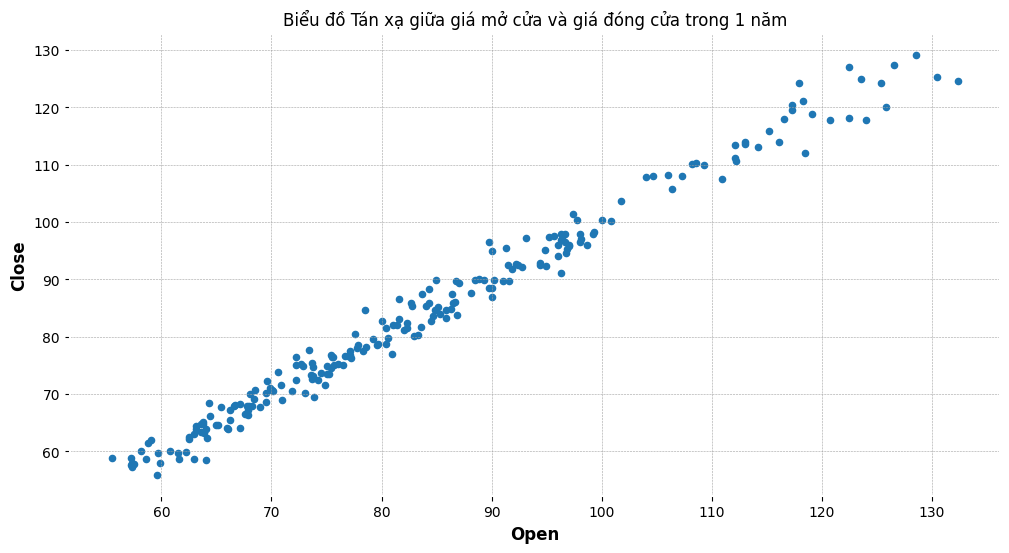

In [129]:
df = pd.read_csv('AMD_(1980 -11.07.2023).csv_without_Adj_Close.csv', parse_dates=['Date'])

# Đặt cột 'Date' làm chỉ mục
df.set_index('Date', inplace=True)

### 1. Lấy mẫu ngẫu nhiên 1000 dòng để hiển thị
df_sampled = df.sample(10918)

### 2. Lấy dữ liệu của 1 năm gần nhất
df_last_year = df.tail(225)  # 225 giao dịch gần nhất (trong năm 2023)

# Biểu đồ đường cho dữ liệu 1 năm
df_last_year[['Open', 'Close']].plot(figsize=(12, 6), title="Biểu đồ giá cổ phiếu trong 1 năm gần nhất")
plt.show()

### 3. Lấy dữ liệu 5 năm gần nhất
df_last_five_year = df.tail(1262) #1266 giao dịch gần nhất (2018 ~ 2023)
df_last_five_year[['Open', 'Close']].plot(figsize=(12, 6), title="Biểu đồ giá cổ phiếu trong 5 năm gần nhất")
plt.show()

### 4. Tổng hợp dữ liệu theo tháng
df_monthly = df.resample('ME').mean()  # Tính trung bình theo tháng

# Biểu đồ đường cho dữ liệu tổng hợp theo tháng
df_monthly[['Open', 'Close']].plot(figsize=(12, 6), title="Biểu đồ giá cổ phiếu trung bình theo tháng")
plt.show()

### 5. Ma trận tương quan chỉ với dữ liệu 1000 dòng (để giảm quá tải)
df_sampled_corr = df_sampled[['Open', 'Close', 'High', 'Low', 'Volume', 'Prev_close']].corr()
sns.heatmap(df_sampled_corr, annot=True, cmap='coolwarm')
plt.title("Ma trận tương quan (full dữ liệu)")
plt.show()

### 6. Biểu đồ tán xạ giữa giá mở cửa và giá đóng cửa trong vòng 1 năm
df_last_year.plot(kind='scatter', x='Open', y='Close', figsize=(12, 6), title="Biểu đồ Tán xạ giữa giá mở cửa và giá đóng cửa trong 1 năm")
plt.show()

import plotly.graph_objects as go

### 7.Tạo biểu đồ nến
fig = go.Figure(data=[go.Candlestick(x=df_last_year.index,
                                     open=df_last_year['Open'],
                                     high=df_last_year['High'],
                                     low=df_last_year['Low'],
                                     close=df_last_year['Close'])])

fig.update_layout(title="Biểu đồ Nến (Candle Stick) trong 1 năm",
                  xaxis_title="Ngày",
                  yaxis_title="Giá cổ phiếu")

fig.show()

# Nếu không hiển thị, thử lưu ra file HTML
fig.write_html("candlestick_chart.html")

# 3. Thực nghiệm với thuật toán Linear Regression

In [313]:
# Đọc dữ liệu từ file
df = pd.read_csv('AMD_(1980 -11.07.2023).csv_without_Adj_Close.csv', parse_dates=['Date'])

#define target x and y (calculate close)
x = df[['Open', 'High', 'Low', 'Prev_close', 'Volume']]
y = df['Close']

#allocate data for training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)

#train data check
print(x_train.shape, x_test.shape)

(8188, 5) (2730, 5)


In [314]:
#linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

In [315]:
#print regressor
#coef hệ số của pt tuyến tính
#coef cho biết giá trị các cột khi tăng 1 thì sẽ tăng giảm theo giá trị trong mảng coef
#intercept hệ số chặn của ptt tt
#là giá trị biến phụ thuộc khi mọi biến độc lập = 0
print(regressor.coef_)
print(regressor.intercept_)

[-4.30879089e-02  6.93093328e-01  6.78960103e-01 -3.29648514e-01
  2.73049805e-10]
-0.01371856896918544


In [316]:
#predicted value
predicted = regressor.predict(x_test)
print(x_test)
print(predicted)

            Open       High        Low  Prev_close    Volume
1533   15.000000  15.437500  14.875000   15.125000    763800
4439   14.375000  15.437500  14.312500   15.000000   9376200
7603    8.300000   8.670000   7.920000    8.270000  48469500
1312   14.625000  14.687500  14.312500   14.625000    271800
5975   17.549999  17.559999  16.850000   17.860001  12035800
...          ...        ...        ...         ...       ...
10211  79.349998  79.720001  76.540001   78.930000  38393500
7029    7.100000   7.490000   6.980000    7.150000  20428500
9567   12.140000  12.430000  12.050000   12.070000  42265200
3852   17.562500  17.875000  17.375000   17.625000   2343600
4782    8.562500   9.000000   8.468750    8.562500   3083800

[2730 rows x 5 columns]
[15.15339736 14.84196992  8.30217633 ... 12.29249646 17.60610992
  8.78335116]


In [317]:
predicted.shape

(2730,)

In [318]:
#Comparison predicted to actual test
_datafile = pd.DataFrame({"Actual": y_test, "Predicted": predicted})
print(_datafile)

          Actual  Predicted
1533   15.250000  15.153397
4439   15.312500  14.841970
7603    8.380000   8.302176
1312   14.375000  14.432510
5975   17.360001  16.957048
...          ...        ...
10211  76.660004  77.779590
7029    7.460000   7.259359
9567   12.420000  12.292496
3852   17.875000  17.606110
4782    8.812500   8.783351

[2730 rows x 2 columns]


In [319]:
#Score
regressor.score(x_test, y_test)

0.9997230866660051

In [320]:
import math
print("Mean Absolute Error ", metrics.mean_absolute_error(y_test, predicted))
print("Mean Square Error ", metrics.mean_squared_error(y_test, predicted))
print("Root Mean Error ", math.sqrt(metrics.mean_squared_error(y_test, predicted)))

Mean Absolute Error  0.1899980268856145
Mean Square Error  0.14996326712845848
Root Mean Error  0.3872509097839003


In [321]:
predicted = regressor.predict(x)
print(predicted)

[  3.17517759   3.15019536   3.06088465 ... 111.36871184 114.35309656
 111.17082262]


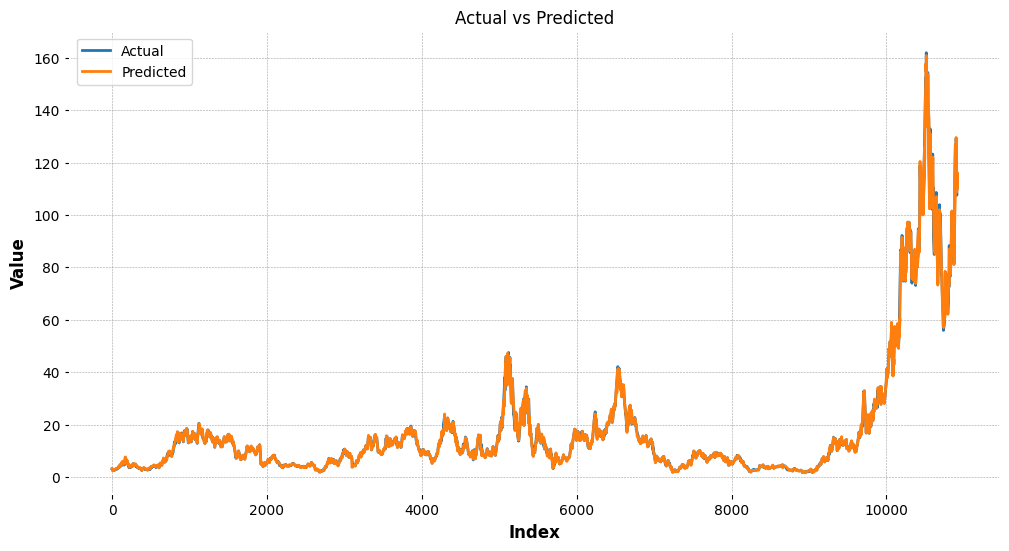

In [322]:
#plot the graph
plt.figure(figsize=(12, 6))
plt.plot(y, label = "Actual")
plt.plot(predicted, label = "Predicted")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

# New Data

In [323]:
#load test data
new_data = pd.read_csv("AMD (2023 - 08.04.2024).csv")
new_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-03,66.000000,66.879997,63.590000,64.019997,64.019997,46851800
1,2023-01-04,65.000000,65.790001,63.310001,64.660004,64.660004,47477100
2,2023-01-05,64.150002,64.349998,62.299999,62.330002,62.330002,46159500
3,2023-01-06,63.150002,64.300003,60.049999,63.959999,63.959999,70161300
4,2023-01-09,66.220001,69.320000,65.669998,67.239998,67.239998,69741300


In [324]:
# Add Prev_close column
series_shifted = new_data['Close'].shift()
new_data['Prev_close'] = series_shifted
new_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Prev_close
0,2023-01-03,66.000000,66.879997,63.590000,64.019997,64.019997,46851800,NaN
1,2023-01-04,65.000000,65.790001,63.310001,64.660004,64.660004,47477100,64.019997
2,2023-01-05,64.150002,64.349998,62.299999,62.330002,62.330002,46159500,64.660004
3,2023-01-06,63.150002,64.300003,60.049999,63.959999,63.959999,70161300,62.330002
4,2023-01-09,66.220001,69.320000,65.669998,67.239998,67.239998,69741300,63.959999


In [325]:
#Drop unused column for test data
new_data = new_data.drop(columns = ['Adj Close'])
new_data.head()

,Date,Open,High,Low,Close,Volume,Prev_close
0,2023-01-03,66.000000,66.879997,63.590000,64.019997,46851800,NaN
1,2023-01-04,65.000000,65.790001,63.310001,64.660004,47477100,64.019997
2,2023-01-05,64.150002,64.349998,62.299999,62.330002,46159500,64.660004
3,2023-01-06,63.150002,64.300003,60.049999,63.959999,70161300,62.330002
4,2023-01-09,66.220001,69.320000,65.669998,67.239998,69741300,63.959999


In [326]:
new_data.shape

(316, 7)

In [327]:
#null entries check (need to remove those data)
new_data.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Prev_close    1
dtype: int64

In [328]:
# remove null row/column
new_data.dropna(inplace = True)
new_data

,Date,Open,High,Low,Close,Volume,Prev_close
1,2023-01-04,65.000000,65.790001,63.310001,64.660004,47477100,64.019997
2,2023-01-05,64.150002,64.349998,62.299999,62.330002,46159500,64.660004
3,2023-01-06,63.150002,64.300003,60.049999,63.959999,70161300,62.330002
4,2023-01-09,66.220001,69.320000,65.669998,67.239998,69741300,63.959999
5,2023-01-10,66.669998,68.150002,66.559998,68.050003,41149600,67.239998
...,...,...,...,...,...,...,...
311,2024-04-01,180.100006,187.240005,179.899994,183.339996,74299900,180.490005
312,2024-04-02,179.470001,180.100006,174.830002,178.699997,61598800,183.339996
313,2024-04-03,177.539993,182.050003,176.699997,180.770004,49835100,178.699997
314,2024-04-04,182.919998,183.020004,165.649994,165.830002,88280000,180.770004


In [329]:
#define target x and y (calculate close)
x_new = new_data[['Open', 'High', 'Low', 'Prev_close', 'Volume']]
y_new = new_data['Close']

In [330]:
#predicted value with new data
new_predicted = regressor.predict(x_new)
print(x_new)
print(new_predicted)

           Open        High         Low  Prev_close    Volume
1     65.000000   65.790001   63.310001   64.019997  47477100
2     64.150002   64.349998   62.299999   64.660004  46159500
3     63.150002   64.300003   60.049999   62.330002  70161300
4     66.220001   69.320000   65.669998   63.959999  69741300
5     66.669998   68.150002   66.559998   67.239998  41149600
..          ...         ...         ...         ...       ...
311  180.100006  187.240005  179.899994  180.490005  74299900
312  179.470001  180.100006  174.830002  183.339996  61598800
313  177.539993  182.050003  176.699997  178.699997  49835100
314  182.919998  183.020004  165.649994  180.770004  88280000
315  168.100006  172.690002  165.580002  165.830002  66025200

[315 rows x 5 columns]
[ 64.67800962  62.81948959  62.07490145  68.70026237  67.38517587
  68.17229804  69.49339554  69.9337445   71.86793105  71.61083249
  67.44764118  69.15090222  75.45583912  73.87198333  73.24546784
  75.86641464  75.13494552  72.834

In [331]:
#Comparison predicted to actual test
_new_data = pd.DataFrame({"Actual": y_new, "Predicted": new_predicted})
print(_new_data)

         Actual   Predicted
1     64.660004   64.678010
2     62.330002   62.819490
3     63.959999   62.074901
4     67.239998   68.700262
5     68.050003   67.385176
..          ...         ...
311  183.339996  184.667891
312  178.699997  175.361065
313  180.770004  179.591764
314  165.830002  171.857863
315  170.419998  170.208121

[315 rows x 2 columns]


In [332]:
#Score
regressor.score(x_new, y_new)

0.9978410578879148

In [333]:
import math
print("Mean Absolute Error ", metrics.mean_absolute_error(y_new, new_predicted))
print("Mean Square Error ", metrics.mean_squared_error(y_new, new_predicted))
print("Root Mean Error ", math.sqrt(metrics.mean_squared_error(y_new, new_predicted)))

Mean Absolute Error  1.1785508914163099
Mean Square Error  2.5039485102379184
Root Mean Error  1.5823869660225083


In [334]:
new_predicted = regressor.predict(x_new)

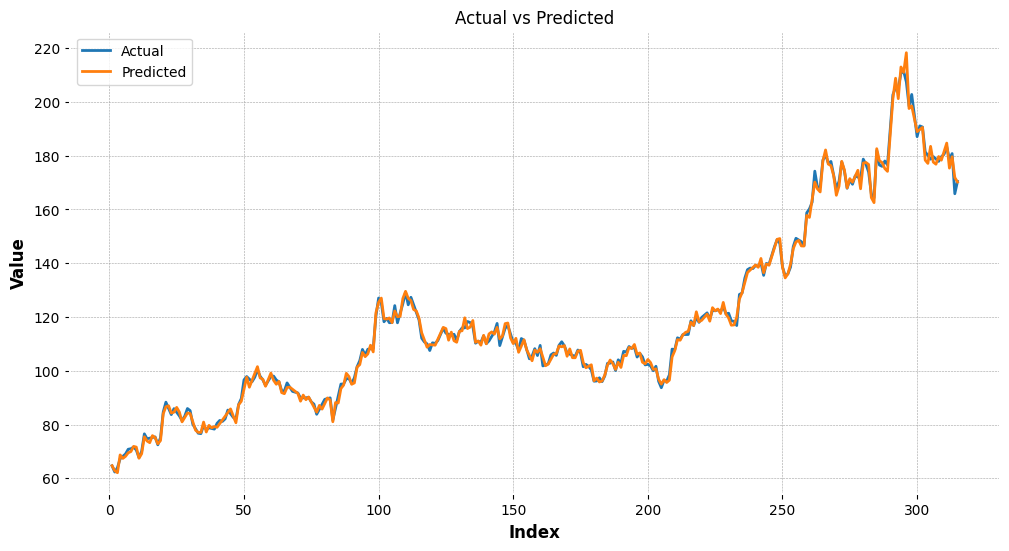

In [335]:
#plot the graph
plt.figure(figsize=(12, 6))
plt.plot(y_new.index, y_new, label = "Actual")
plt.plot(y_new.index, new_predicted, label = "Predicted")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Actual vs Predicted")
plt.legend()
plt.show()